In [1]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

W0905 18:50:00.558682 139710269712128 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0905 18:50:00.560204 139710269712128 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.



In [4]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

In [11]:
! pip install jupyterlab==1.0 "ipywidgets>=7.5"

    100% |████████████████████████████████| 16.6MB 73kB/s 
    100% |████████████████████████████████| 122kB 8.5MB/s 
    100% |████████████████████████████████| 2.2MB 570kB/s 
    100% |████████████████████████████████| 61kB 9.9MB/s 
  Found existing installation: jupyterlab 0.34.12
    Uninstalling jupyterlab-0.34.12:
      Successfully uninstalled jupyterlab-0.34.12
  Found existing installation: widgetsnbextension 3.0.2
    Uninstalling widgetsnbextension-3.0.2:
      Successfully uninstalled widgetsnbextension-3.0.2
  Rolling back uninstall of widgetsnbextension
Exception:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pip/commands/install.py", line 342, in run
    prefix=options.prefix_path,
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pip/req/req_set.py", line 784, in ins

In [14]:
#!pip install plotly
!pip install chart-studio

    100% |████████████████████████████████| 81kB 1.5MB/s 
You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [40]:
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import chart_studio.offline as pyoff
import plotly.graph_objects as go

In [20]:
!pip install xgboost

    100% |████████████████████████████████| 142.8MB 8.3kB/s 
You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [29]:
# choose a name for experiment
experiment_name = 'automl-comparision-clv'
# project folder
project_folder = './mnt/azmnt/code/Users/WA_Fn-UseC_-Telco-Customer-Churn'

In [30]:
experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.57
Subscription ID,c66c342f-a989-4745-8c62-9ab2480be04e
Workspace,test_env2
Resource Group,churn_clv_training
Location,westeurope
Project Directory,./mnt/azmnt/code/Users/WA_Fn-UseC_-Telco-Customer-Churn
Experiment Name,automl-comparision-clv


In [31]:
# Create or Attach existing AmlCompute
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "curn-clv"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
    
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D2_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                max_nodes = 6)

    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
print('Checking cluster status...')
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)

# For a more detailed view of current AmlCompute status, use get_status().

Found existing compute target.
Checking cluster status...
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


In [32]:
#data
if not os.path.isdir('data'):
    os.mkdir('data')
    
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

In [33]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
import pkg_resources

# create a new RunConfig object
conda_run_config = RunConfiguration(framework="python")

# Set compute target to AmlCompute
conda_run_config.target = compute_target
conda_run_config.environment.docker.enabled = True

cd = CondaDependencies.create(conda_packages=['numpy','py-xgboost<=0.80'])
conda_run_config.environment.python.conda_dependencies = cd

In [34]:
df_data = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [35]:
df_data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [36]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [37]:
df_data.loc[df_data.Churn=='No','Churn'] = 0 
df_data.loc[df_data.Churn=='Yes','Churn'] = 1

In [38]:
df_data.groupby('gender').Churn.mean()

gender
Female   0.27
Male     0.26
Name: Churn, dtype: float64

In [42]:
init_notebook_mode(connected=True)

In [43]:
df_plot = df_data.groupby('gender').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['gender'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Gender',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)

In [44]:
df_plot = df_data.groupby('Partner').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['Partner'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Partner',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)

In [45]:
df_plot = df_data.groupby('PhoneService').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['PhoneService'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Phone Service',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
        
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)

In [46]:
df_plot = df_data.groupby('MultipleLines').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['MultipleLines'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Multiple Lines',
        yaxis={"title": "Churn Rate"},
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)

In [47]:
df_plot = df_data.groupby('InternetService').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['InternetService'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Internet Service',
        yaxis={"title": "Churn Rate"},
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)

In [48]:
df_data.tenure.describe()

count   7043.00
mean    32.37  
std     24.56  
min     0.00   
25%     9.00   
50%     29.00  
75%     55.00  
max     72.00  
Name: tenure, dtype: float64

In [49]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

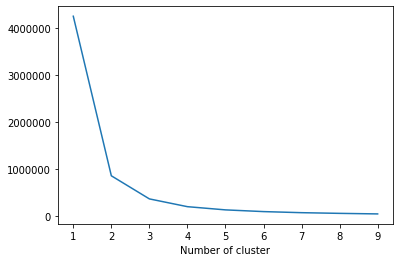

In [50]:
sse={}
df_cluster = df_data[['tenure']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [51]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['tenure']])
df_data['TenureCluster'] = kmeans.predict(df_data[['tenure']])

In [52]:
df_data = order_cluster('TenureCluster', 'tenure',df_data,True)

In [53]:
df_data.groupby('TenureCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
0,2941.00,7.80,6.23,0.00,2.00,6.00,13.00,21.00
1,1863.00,34.29,7.99,22.00,27.00,34.00,41.00,48.00
2,2239.00,63.05,7.48,49.00,56.00,64.00,70.00,72.00


In [54]:
df_data['TenureCluster'] = df_data["TenureCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [56]:
df_plot = df_data.groupby('TenureCluster').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['TenureCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5,0.5],
        marker=dict(
        color=['green', 'blue', 'orange','red'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Tenure Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)

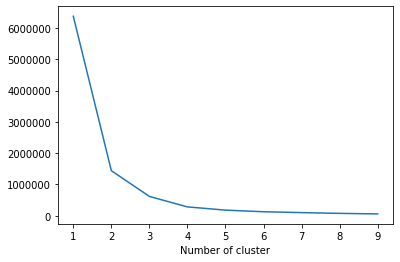

In [57]:
sse={}
df_cluster = df_data[['MonthlyCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [58]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['MonthlyCharges']])
df_data['MonthlyChargeCluster'] = kmeans.predict(df_data[['MonthlyCharges']])

In [59]:
df_data = order_cluster('MonthlyChargeCluster', 'MonthlyCharges',df_data,True)

In [60]:
df_data.groupby('MonthlyChargeCluster').MonthlyCharges.describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargeCluster,,,,,,,,
0,1892.00,23.38,5.66,18.25,19.80,20.40,25.05,42.40
1,2239.00,61.63,10.44,42.60,51.80,61.55,70.70,77.80
2,2912.00,94.05,10.34,77.85,85.05,93.90,101.91,118.75


In [61]:
df_data['MonthlyChargeCluster'] = df_data["MonthlyChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [62]:
df_plot = df_data.groupby('MonthlyChargeCluster').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['MonthlyChargeCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Monthly Charge Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#iplot(fig)

In [63]:
iplot(fig)

In [64]:
df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureCluster,MonthlyChargeCluster
92,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.25,,0,Low,Low
138,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,25.75,,0,Low,Low
425,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,19.85,,0,Low,Low
488,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,25.35,,0,Low,Low
566,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,20.00,,0,Low,Low
681,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0,Low,Low
1977,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0,Low,Mid
2116,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,No,Two year,No,Credit card (automatic),56.05,,0,Low,Mid
3016,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,No,Two year,No,Mailed check,73.35,,0,Low,Mid
3029,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,No,Two year,Yes,Bank transfer (automatic),61.90,,0,Low,Mid


In [65]:
len(df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()])

11

In [66]:
df_data.loc[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull(),'TotalCharges'] = np.nan

In [67]:
df_data = df_data.dropna()

In [68]:
df_data['TotalCharges'] = pd.to_numeric(df_data['TotalCharges'], errors='coerce')

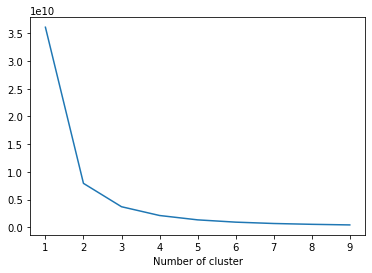

In [69]:
sse={}
df_cluster = df_data[['TotalCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [70]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['TotalCharges']])
df_data['TotalChargeCluster'] = kmeans.predict(df_data[['TotalCharges']])

In [71]:
df_data = order_cluster('TotalChargeCluster', 'TotalCharges',df_data,True)

In [72]:
df_data.groupby('TotalChargeCluster').TotalCharges.describe()

,count,mean,std,min,25%,50%,75%,max
TotalChargeCluster,,,,,,,,
0,4160.00,686.20,572.03,18.80,161.49,535.95,1139.41,1975.85
1,1613.00,3272.60,814.14,1978.65,2548.65,3211.20,3970.40,4779.45
2,1259.00,6292.97,1003.37,4783.50,5468.70,6145.85,7040.15,8684.80


In [73]:
df_data['TotalChargeCluster'] = df_data["TotalChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [74]:
df_plot = df_data.groupby('TotalChargeCluster').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['TotalChargeCluster'],
        y=df_plot['Churn'],
        width = [0.5, 0.5, 0.5],
        marker=dict(
        color=['green', 'blue', 'orange'])
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category","categoryarray":['Low','Mid','High']},
        title='Total Charge Cluster vs Churn Rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#iplot(fig)

In [75]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 24 columns):
customerID              7032 non-null object
gender                  7032 non-null object
SeniorCitizen           7032 non-null int64
Partner                 7032 non-null object
Dependents              7032 non-null object
tenure                  7032 non-null int64
PhoneService            7032 non-null object
MultipleLines           7032 non-null object
InternetService         7032 non-null object
OnlineSecurity          7032 non-null object
OnlineBackup            7032 non-null object
DeviceProtection        7032 non-null object
TechSupport             7032 non-null object
StreamingTV             7032 non-null object
StreamingMovies         7032 non-null object
Contract                7032 non-null object
PaperlessBilling        7032 non-null object
PaymentMethod           7032 non-null object
MonthlyCharges          7032 non-null float64
TotalCharges            7032 non-null f

In [76]:
#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns

for column in df_data.columns:
    if df_data[column].dtype == object and column != 'customerID':
        if df_data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column]) 
        else:
            dummy_columns.append(column)

#apply get dummies for selected columns
df_data = pd.get_dummies(data = df_data,columns = dummy_columns) 

In [77]:
df_data[['gender','Partner','TenureCluster_High','TenureCluster_Low','TenureCluster_Mid']].head()

,gender,Partner,TenureCluster_High,TenureCluster_Low,TenureCluster_Mid
0,0,1,0,1,0
1,0,0,0,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,1,1,0,1,0


In [78]:
all_columns = []
for column in df_data.columns:
    column = column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_")
    all_columns.append(column)

df_data.columns = all_columns

In [79]:
glm_columns = 'gender'

for column in df_data.columns:
    if column not in ['Churn','customerID','gender']:
        glm_columns = glm_columns + ' + ' + column

In [80]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
 

glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=df_data, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                            GLM   Df Residuals:                     7002
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2900.1
Date:                Thu, 05 Sep 2019   Deviance:                       5800.1
Time:                        19:29:48   Pearson chi2:                 7.58e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [81]:
np.exp(res.params)

Intercept                                 1.29
gender                                    0.98
SeniorCitizen                             1.25
Partner                                   1.00
Dependents                                0.87
tenure                                    0.94
PhoneService                              1.25
PaperlessBilling                          1.42
MonthlyCharges                            0.97
TotalCharges                              1.00
MultipleLines_No                          0.89
MultipleLines_No_phone_service            1.03
MultipleLines_Yes                         1.41
InternetService_DSL                       0.55
InternetService_Fiber_optic               2.82
InternetService_No                        0.83
OnlineSecurity_No                         1.39
OnlineSecurity_No_internet_service        0.83
OnlineSecurity_Yes                        1.13
OnlineBackup_No                           1.25
OnlineBackup_No_internet_service          0.83
OnlineBackup_

In [82]:
#create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn

In [83]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [84]:
#building the model
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.81


In [85]:
y_pred = xgb_model.predict(X_test)

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       267
           1       0.62      0.51      0.56        85

   micro avg       0.81      0.81      0.81       352
   macro avg       0.74      0.70      0.72       352
weighted avg       0.80      0.81      0.80       352



In [92]:
!pip install graphviz

You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [95]:
!conda install python-graphviz -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /anaconda

  added / updated specs: 
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libedit-3.1.20181209       |       hc058e9b_0         188 KB
    graphviz-2.40.1            |       h21bd128_2         6.9 MB
    wheel-0.33.4               |           py37_0          39 KB
    pixman-0.38.0              |       h7b6447c_0         618 KB
    certifi-2019.6.16          |           py37_1         156 KB
    python-graphviz-0.10.1     |             py_0          22 KB
    pip-19.2.2                 |           py37_0         1.9 MB
    python-3.7.4               |       h265db76_1        36.5 MB
    sqlite-3.29.0    

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

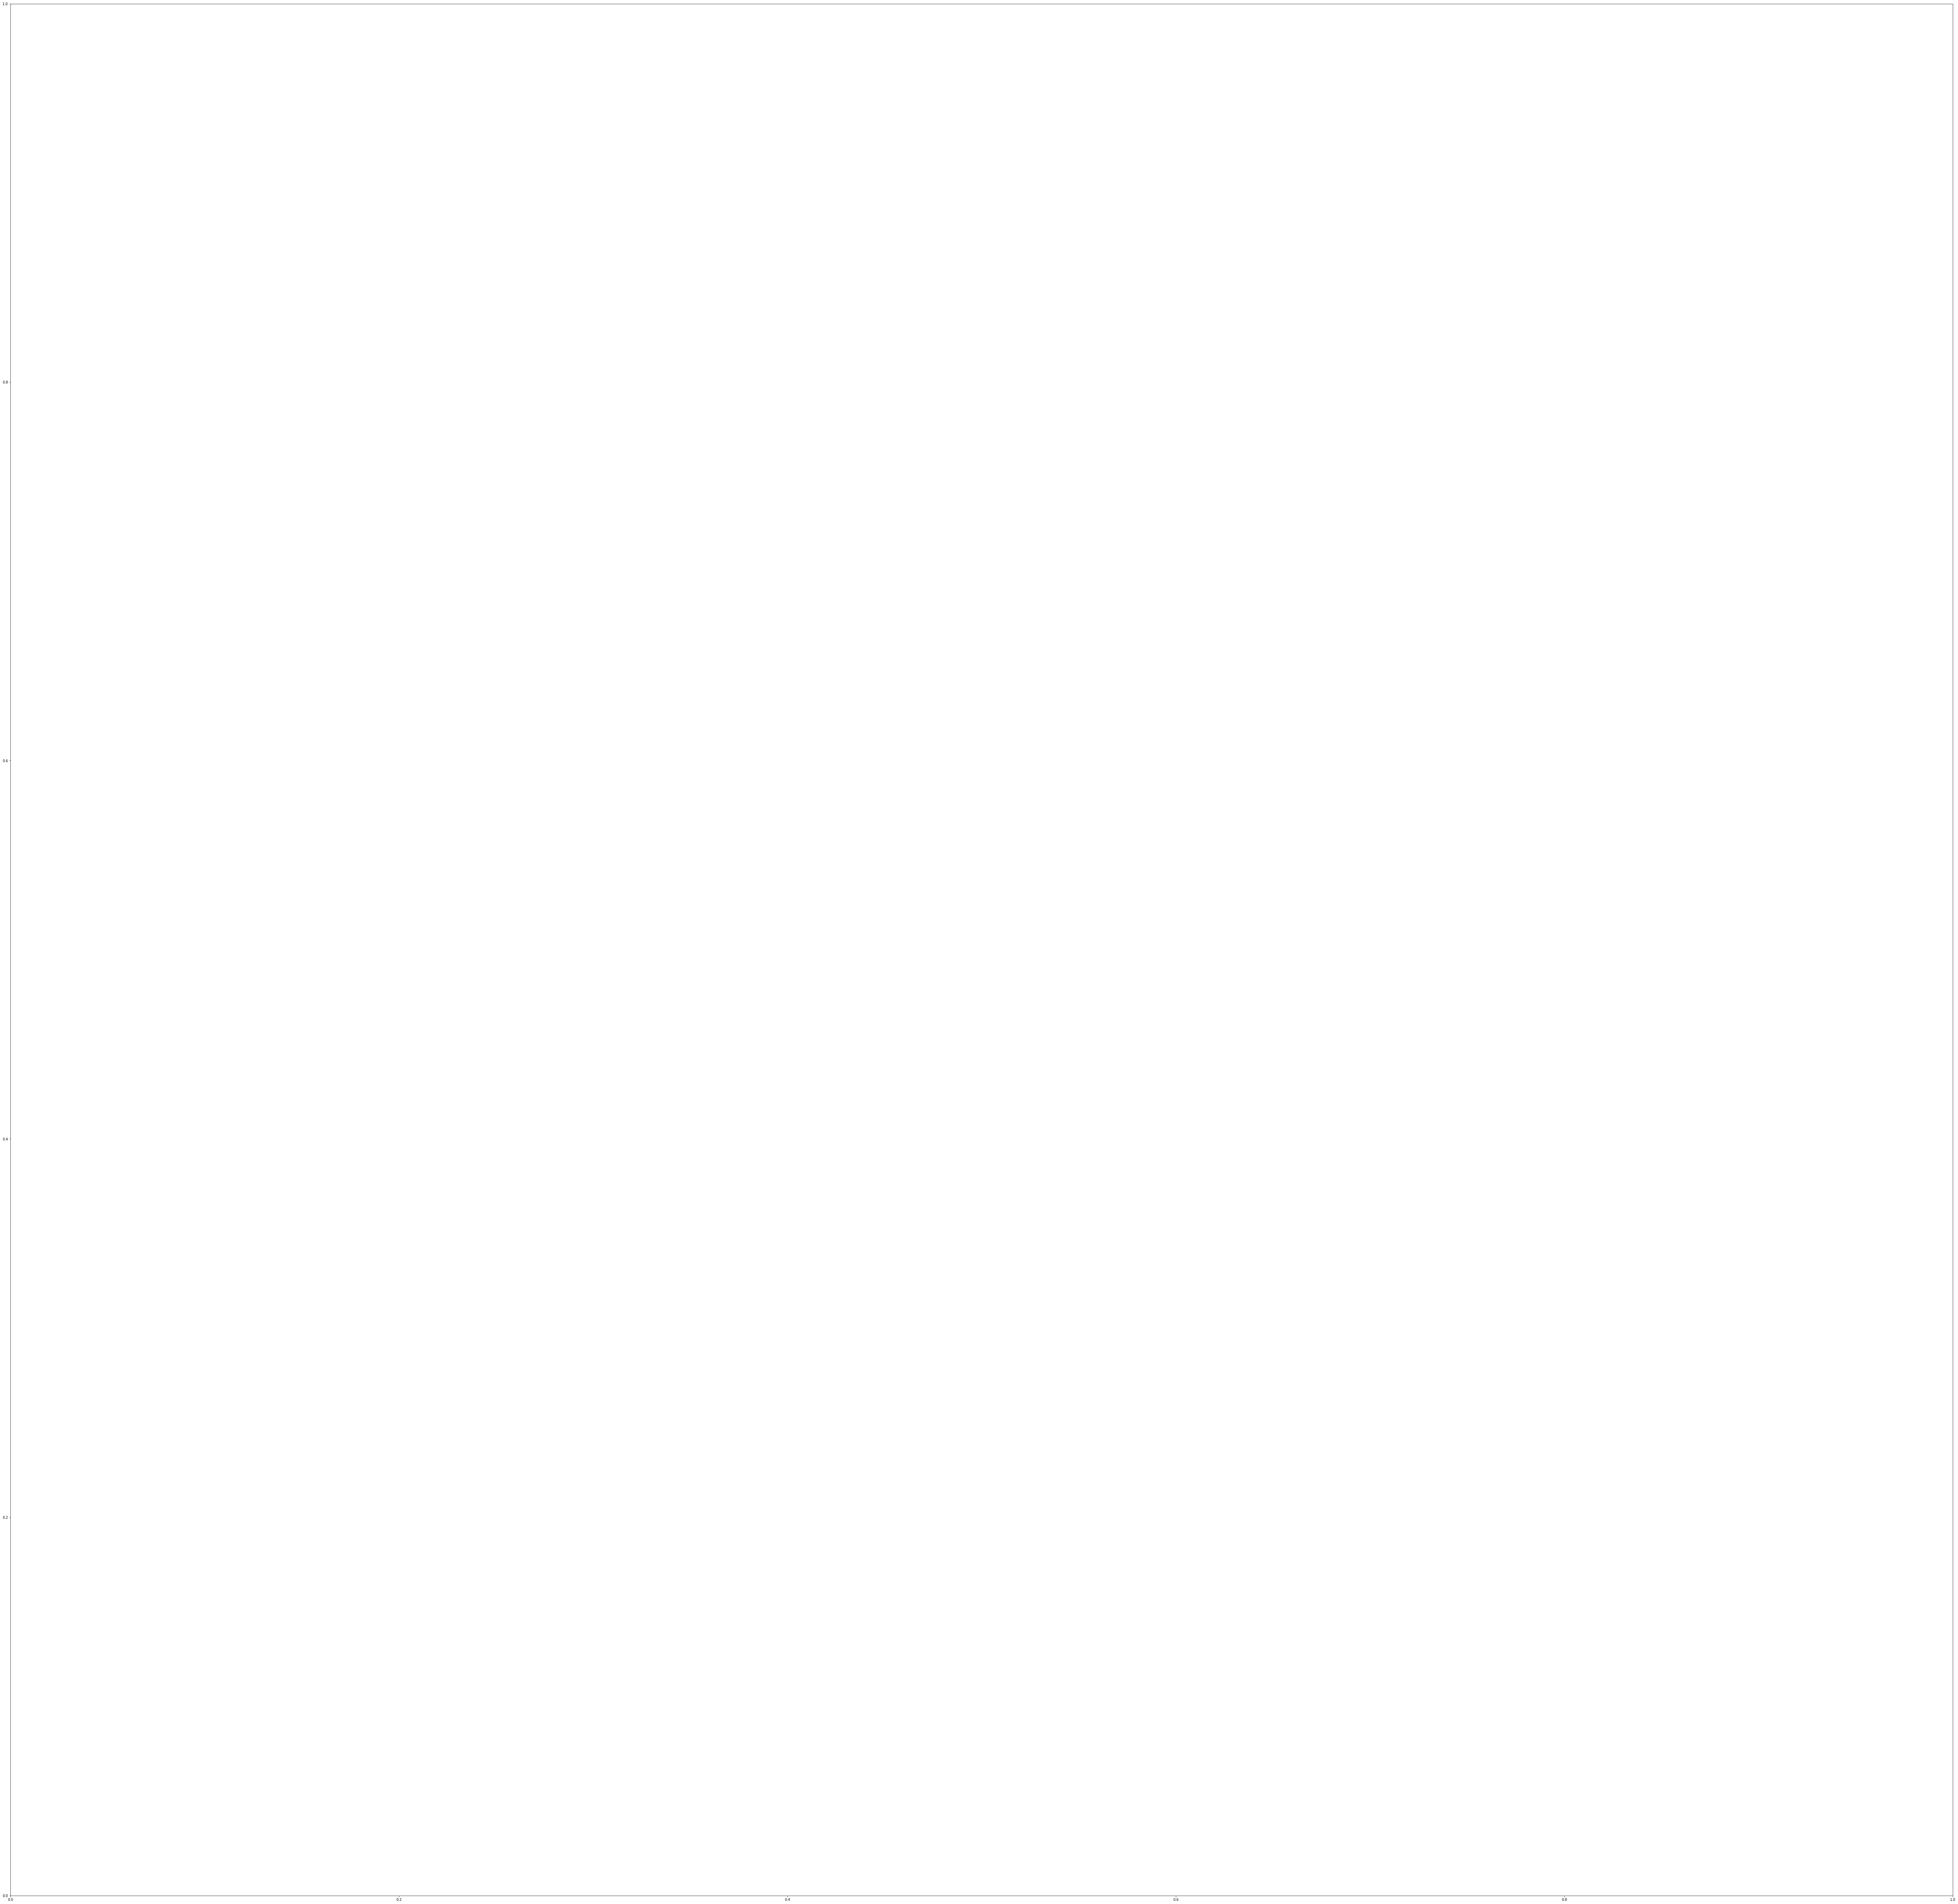

In [98]:
from xgboost import plot_tree

##set up the parameters
fig, ax = plt.subplots(figsize=(100,100))
plot_tree(xgb_model, ax=ax)

In [99]:
1/(1+np.exp(-0.032))


0.5079993174032311

In [100]:
from xgboost import plot_importance

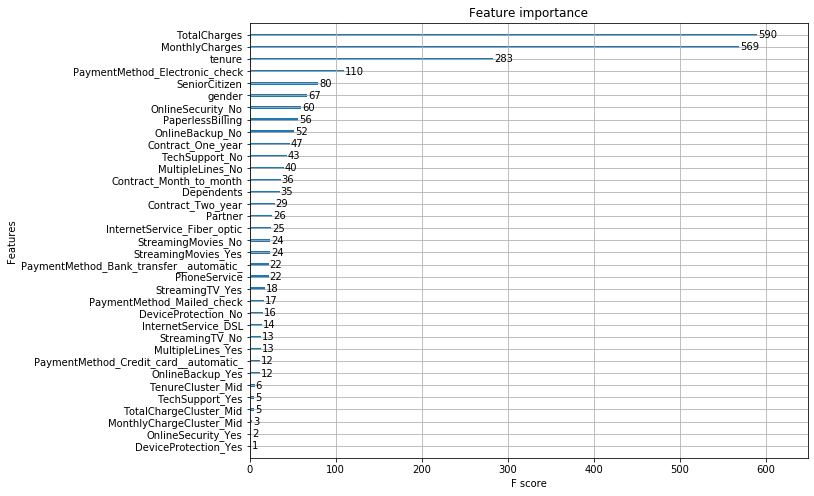

In [101]:
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

In [102]:
df_data['proba'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]

In [103]:
df_data[['customerID', 'proba']].head()

,customerID,proba
0,7590-VHVEG,0.49
1,6713-OKOMC,0.11
2,7469-LKBCI,0.02
3,8779-QRDMV,0.92
4,1680-VDCWW,0.04
